In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
from numpy.random import multivariate_normal
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

tickers = ["AAPL", "GOOG", "META", "CAT"]
benchmark = "^GSPC"
start_date = "1999-01-01"
end_date = "2024-12-31"
management_fee = 0.02
performance_fee_rate = 0.2
risk_free_rate = 0.01
n_simulations = 10000
n_days = 252



In [19]:
data = yf.download(tickers + [benchmark], start=start_date, end=end_date, interval="1d", group_by='ticker', auto_adjust=True)

def compute_log_returns(prices):
    return np.log(prices / prices.shift(1)).dropna()

returns = {
    ticker: compute_log_returns(data[ticker]['Close']) for ticker in tickers
}
benchmark_returns = compute_log_returns(data[benchmark]['Close'])

returns_df = pd.DataFrame(returns)
mean_returns = returns_df.mean().values
cov_matrix = returns_df.cov().values

simulated_returns = multivariate_normal(mean_returns, cov_matrix, (n_simulations, n_days))



[*********************100%***********************]  5 of 5 completed


In [20]:
def random_weights(n_assets):
    w = np.random.rand(n_assets)
    return w / np.sum(w)

weights_list = np.array([random_weights(len(tickers)) for _ in range(n_simulations)])

portfolio_returns = np.einsum('ijk,ik->ij', simulated_returns, weights_list)
portfolio_cum_returns = np.exp(portfolio_returns.cumsum(axis=1))

hist_df = returns_df
hist_mean_returns = hist_df.mean()
hist_cov = hist_df.cov()

sharpe_ratios = []
weights_store = []

for _ in range(10000):
    w = random_weights(len(tickers))
    port_return = np.dot(hist_mean_returns, w)
    port_vol = np.sqrt(np.dot(w.T, np.dot(hist_cov, w)))
    sharpe = (port_return - risk_free_rate) / port_vol
    sharpe_ratios.append(sharpe)
    weights_store.append(w)

best_weights = weights_store[np.argmax(sharpe_ratios)]

print("Run 42 selected for backtesting")

hist_portfolio_returns = hist_df.dot(best_weights)
hist_portfolio_cum = np.exp(hist_portfolio_returns.cumsum())



Run 42 selected for backtesting


In [21]:
def apply_fees(nav_series, management_fee, performance_fee_rate, benchmark_nav):
    nav = nav_series.copy()
    annual_nav = nav.resample('Y').last().squeeze()
    annual_benchmark = benchmark_nav.resample('Y').last().squeeze()
    gross_returns = annual_nav.pct_change().dropna()
    benchmark_returns = annual_benchmark.pct_change().dropna()
    alpha = (gross_returns - benchmark_returns).mean()
    perf_fee = alpha * performance_fee_rate if alpha > 0 else 0
    net_returns = gross_returns - management_fee - perf_fee
    net_nav = [annual_nav.iloc[0]]
    for r in net_returns:
        net_nav.append(net_nav[-1] * (1 + r))
    return pd.Series(net_nav[1:], index=net_returns.index)

benchmark_cum = np.exp(benchmark_returns.cumsum())
fees_applied_nav = apply_fees(hist_portfolio_cum.to_frame(name="NAV"), management_fee, performance_fee_rate, benchmark_cum.to_frame(name="Benchmark"))

aligned_returns = pd.concat([benchmark_returns, hist_portfolio_returns], axis=1).dropna()
x = aligned_returns.iloc[:, 0].values.reshape(-1, 1)
y = aligned_returns.iloc[:, 1].values



/tmp/ipython-input-2736511730.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_nav = nav.resample('Y').last().squeeze()
/tmp/ipython-input-2736511730.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_benchmark = benchmark_nav.resample('Y').last().squeeze()


In [22]:
model = LinearRegression().fit(x, y)
beta = model.coef_[0]
alpha = model.intercept_
sharpe_ratio = (hist_portfolio_returns.mean() - risk_free_rate) / hist_portfolio_returns.std()

print(f"Alpha: {alpha:.4f}")
print(f"Beta: {beta:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")



Alpha: 0.0003
Beta: 1.1592
Sharpe Ratio: -0.5372


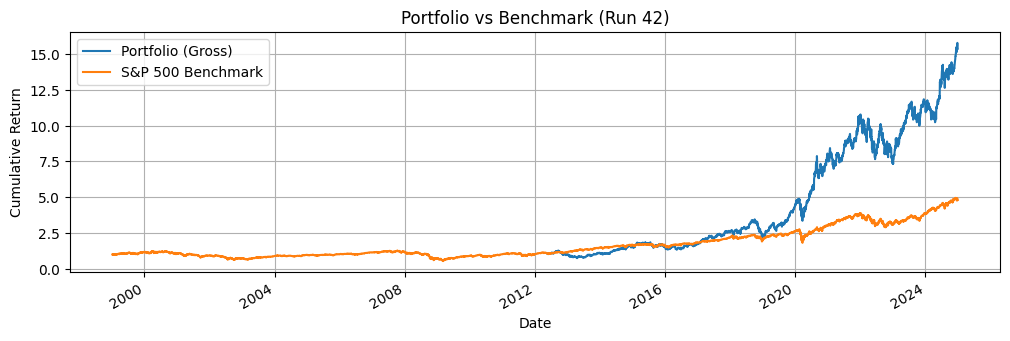

In [23]:
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
hist_portfolio_cum.plot(label="Portfolio (Gross)")
benchmark_cum.plot(label="S&P 500 Benchmark")
plt.title("Portfolio vs Benchmark (Run 42)")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()



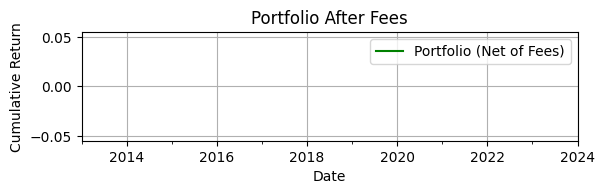

In [24]:
plt.subplot(3, 1, 2)
fees_applied_nav.plot(label="Portfolio (Net of Fees)", color='green')
plt.title("Portfolio After Fees")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()



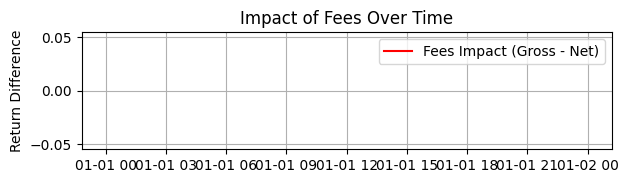

In [25]:
plt.subplot(3, 1, 3)
fee_impact = hist_portfolio_cum.reindex(fees_applied_nav.index).values - fees_applied_nav.values
plt.plot(fees_applied_nav.index, fee_impact, label="Fees Impact (Gross - Net)", color='red')
plt.title("Impact of Fees Over Time")
plt.ylabel("Return Difference")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
